In [1]:
import math

import matplotlib as mpl
from matplotlib import cm
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}', r'\usepackage{newtxmath}'] 
mpl.rc('font', family='serif')

import numpy as np
import pandas as pd
import seaborn as sns
import copy

import matplotlib.pyplot as plt
from matplotlib import rc

from cycler import cycler

from scipy.interpolate import make_interp_spline, BSpline

mpl.rcParams['ps.usedistiller'] = 'xpdf' 

plt.style.use('seaborn-notebook')
# sns.set_palette("Blues_r")

plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '18'
plt.rcParams['ytick.labelsize'] = '18'

monochrome=(cycler('color', sns.color_palette("husl", 8))*2+(cycler('marker', ['v', 's', "o"])*7)[0:16])
plt.rc('axes', prop_cycle=monochrome)

pd.options.display.max_rows = 999
pd.options.display.max_columns = None
cmap = cm.get_cmap('RdBu')

husl4 = sns.color_palette("husl", 4)
husl5 = sns.color_palette("husl", 5)
husl6 = sns.color_palette("husl", 7)
greens5 = sns.color_palette("Greens_r", 5)
purples5 = sns.color_palette("Purples_r", 7)
blues5 = sns.color_palette("Blues_r", 5)
reds5 = sns.color_palette("Reds_r", 8)
oranges5 = sns.color_palette("Oranges_r", 5)
greys5 = sns.color_palette("Greys_r", 5)
winter5 = sns.color_palette("viridis_r", 5)

kitgreen = (43/256,135/256,115/256)
uiucblue = (19/256,42/256,76/256)

In [2]:
folder = "2020-04-28-14-29_SGMRDsearchers_runtime_" # Replace

In [3]:
summary = pd.read_csv("../experiments/" + folder +  "/SGMRDsearchers_runtime.csv", dtype={"searched": "str"})

In [4]:
# some clearning
summary["searched"] = summary["searched"].fillna("")
summary["searched"] =  [x[:-2] if x[-2:] == ".0" else x for x in summary["searched"]]

In [5]:
summary["nsearched"] = [len(x.split("-")) if not pd.isna(x) else 0 for x in summary["searched"] ]
del summary["n"]
del summary["nDim"]

In [6]:
summary["successpercent"] = [x/y if y>0 else None for x,y in zip(summary["success"],summary["ntried"])]

In [7]:
summary["strategy"] = [x.split("-")[3] for x in summary["searcherID"]]
summary["step"] = [x.split("-")[-4] for x in summary["searcherID"]]
summary["L"] =  [x.split("-")[4] for x in summary["searcherID"]]

In [8]:
summary["s"] = [x.split("-")[7] if "MPTS" in x else x.split("-")[6] for x in summary["searcherID"]]

In [9]:
summary["time"] = summary["indextime"] + summary["decisiontime"] + summary["searchtime"]

In [10]:
summary.head()

,refId,refCategory,searcherID,searched,ntried,success,indextime,monitortime,decisiontime,searchtime,nSubspaces,avgSubspaceLength,avgContrast,i,rep,nsearched,successpercent,strategy,step,L,s,time
0,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-1-0.0-1000-100-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,126.7700,0.0,0.0,1.143159e+06,100,3.64,0.9940,0,0,100,0.0,MPTS,100,1,100,1.143286e+06
1,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-20-0.0-1000-100-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,122.7120,0.0,0.0,1.144068e+06,100,3.54,0.9923,0,0,100,0.0,MPTS,100,20,100,1.144190e+06
2,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-100-0.0-1000-100-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,144.9589,0.0,0.0,1.146049e+06,100,3.76,0.9897,0,0,100,0.0,MPTS,100,100,100,1.146194e+06
3,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-2-0.0-1000-100-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,139.7310,0.0,0.0,1.149326e+06,100,3.94,0.9965,0,0,100,0.0,MPTS,100,2,100,1.149466e+06
4,b_1dx100_s,real,SGMRD-KSP-0.9-MPTS-50-0.0-1000-100-0-1-1,0-1-2-3-4-5-6-7-8-9-10-11-12-13-14-15-16-17-18...,100,0,134.2140,0.0,0.0,1.148730e+06,100,3.90,0.9873,0,0,100,0.0,MPTS,100,50,100,1.148864e+06


# Figure 13

In [11]:
summary["searcherID"].unique()

array(['SGMRD-KSP-0.9-MPTS-1-0.0-1000-100-0-1-1',
       'SGMRD-KSP-0.9-MPTS-20-0.0-1000-100-0-1-1',
       'SGMRD-KSP-0.9-MPTS-100-0.0-1000-100-0-1-1',
       'SGMRD-KSP-0.9-MPTS-2-0.0-1000-100-0-1-1',
       'SGMRD-KSP-0.9-MPTS-50-0.0-1000-100-0-1-1',
       'SGMRD-KSP-0.9-MPTS-1-0.0-1000-100-0-0-1',
       'SGMRD-KSP-0.9-MPTS-10-0.0-1000-100-0-1-1',
       'SGMRD-KSP-0.9-MPTS-5-0.0-1000-100-0-1-1'], dtype=object)

In [12]:
summary[summary["searchtime"] != 0].groupby("L").mean()

,ntried,success,indextime,monitortime,decisiontime,searchtime,nSubspaces,avgSubspaceLength,avgContrast,i,rep,nsearched,successpercent,time
L,,,,,,,,,,,,,,
1,2.087912,0.884615,80.689476,5834.012051,0.145825,2.389157e+04,100.0,3.744066,0.928436,4500.0,0.0,2.087912,0.884615,2.397240e+04
10,10.989011,7.945055,119.423646,5613.914498,0.101811,1.245059e+05,100.0,3.355824,0.953774,4500.0,0.0,10.989011,0.794505,1.246255e+05
100,100.000000,52.750000,123.516834,5490.252180,0.110705,1.078679e+06,100.0,3.705682,0.993223,2150.0,0.0,100.000000,0.527500,1.078802e+06
2,3.076923,1.703297,125.333482,5797.813785,0.098631,3.514269e+04,100.0,3.697143,0.935140,4500.0,0.0,3.076923,0.851648,3.526812e+04
20,20.879121,15.637363,113.050188,5471.344489,0.281718,2.290760e+05,100.0,3.520989,0.967640,4500.0,0.0,20.879121,0.781868,2.291893e+05
5,6.043956,4.175824,121.784169,5724.453647,0.095836,6.893837e+04,100.0,3.525275,0.943919,4500.0,0.0,6.043956,0.835165,6.906025e+04
50,50.769231,33.907692,117.552946,5479.532928,0.099297,5.525606e+05,100.0,3.539077,0.984408,3200.0,0.0,50.769231,0.678154,5.526782e+05


In [13]:
selected_searcher = [
                     'SGMRD-KSP-0.9-MPTS-100-0.0-1000-100-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-50-0.0-1000-100-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-20-0.0-1000-100-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-10-0.0-1000-100-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-5-0.0-1000-100-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-2-0.0-1000-100-0-1-1',
                     'SGMRD-KSP-0.9-MPTS-1-0.0-1000-100-0-1-1',
                    ]

In [14]:
subdata = summary[[x in selected_searcher for x in summary["searcherID"]]]
subdata = subdata[subdata["searchtime"] != 0]

In [15]:
purples5 = sns.color_palette("Purples_r", 7)
oranges5 = sns.color_palette("Oranges_r", 5)

cubelix7 = sns.color_palette("cubehelix", 7)

prettynames2 = {
    'SGMRD-KSP-0.9-MPTS-1-0.0-1000-100-0-1-1': "SGMRD-TS, $L=1$",
    'SGMRD-KSP-0.9-MPTS-2-0.0-1000-100-0-1-1': "SGMRD-TS, $L=2$",
    'SGMRD-KSP-0.9-MPTS-5-0.0-1000-100-0-1-1': "SGMRD-TS, $L=5$",
    'SGMRD-KSP-0.9-MPTS-10-0.0-1000-100-0-1-1': "SGMRD-TS, $L=10$",
    'SGMRD-KSP-0.9-MPTS-20-0.0-1000-100-0-1-1': "SGMRD-TS, $L=20$",
    'SGMRD-KSP-0.9-MPTS-50-0.0-1000-100-0-1-1': "SGMRD-TS, $L=50$",
    'SGMRD-KSP-0.9-MPTS-100-0.0-1000-100-0-1-1': "SGMRD-TS, $L=100$",
    'SGMRD-KSP-0.9-All-1000-1000-0-1-1': r'\textsc{GMD-Batch}',
    'SGMRD-KSP-0.9-None-1000-1-0-1-1': r'\textsc{GMD-Init}',
    
}

styledictionary2 = {
    "SGMRD-TS, $L=1$": {'marker': 'X', 'color': cubelix7[0], 'linestyle': "-"},
    "SGMRD-TS, $L=2$": {'marker': 'X', 'color': cubelix7[1], 'linestyle': "-"},
    "SGMRD-TS, $L=5$": {'marker': 'X', 'color': cubelix7[2], 'linestyle': "-"},
    "SGMRD-TS, $L=10$": {'marker': 'X', 'color': cubelix7[3], 'linestyle': "-"},
     "SGMRD-TS, $L=20$": {'marker': 'X', 'color': cubelix7[4], 'linestyle': "-"},
     "SGMRD-TS, $L=50$": {'marker': 'X', 'color': cubelix7[5], 'linestyle': "-"},
     "SGMRD-TS, $L=100$": {'marker': 'X', 'color': cubelix7[6], 'linestyle': "-"},
    r'\textsc{GMD-Batch}':  {'marker': '', 'color': reds5[0], 'linestyle': "--"},
    r'\textsc{GMD-Init}': {'marker': '', 'color': "black", 'linestyle': "--"},
}

<IPython.core.display.Javascript object>


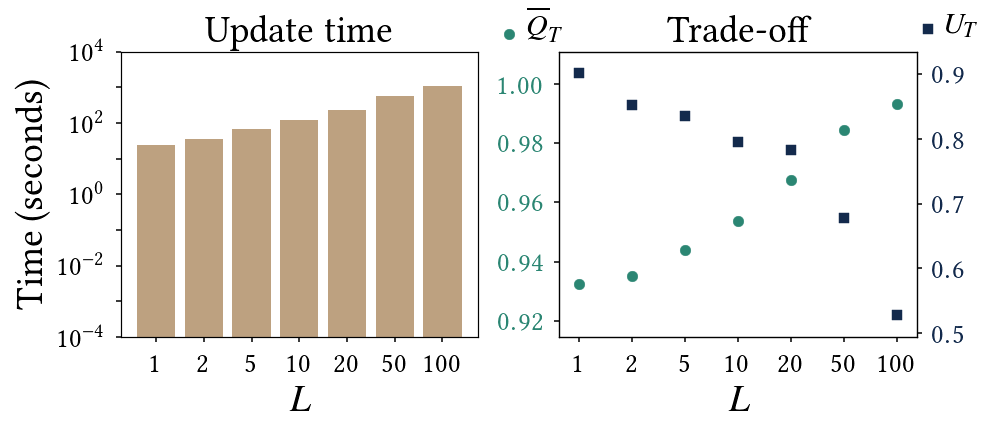

In [17]:
%matplotlib notebook

f, axarr = plt.subplots(1,2, figsize=(9,4), sharey=False)

plt.sca(axarr[0])


toplot = subdata.groupby("L").mean().reset_index()
toplot["L"] = toplot["L"].astype(int)
toplot = toplot.sort_values("L")

plt.bar([i for i,x in enumerate(toplot["L"])], toplot["searchtime"]/1000, 
        label="Update", color=cubelix7[3],  alpha=0.7)

plt.xticks([i for i,x in enumerate(toplot["L"])], [1,2,5,10,20,50,100])
plt.title("Update time")
plt.yscale("log")
plt.ylim(10,2000)
plt.yticks([0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000, 10000],
           ["$10^{-4}$","", "$10^{-2}$", "", "$10^{0}$", "", "$10^{2}$", "", "$10^{4}$"])
plt.xlabel("$L$")
plt.ylabel("Time (seconds)")
plt.tight_layout()

plt.sca(axarr[1])

toplot = subdata.groupby("L").mean().reset_index()
toplot["L"] = toplot["L"].astype(int)
toplot = toplot.sort_values("L")

plt.scatter([i for i,x in enumerate(toplot["L"])], 
            toplot["avgContrast"], label="$\overline{Q}_T$", color=kitgreen,  alpha=1)
plt.xticks([i for i,x in enumerate(toplot["L"])], [1,2,5,10,20,50,100])
plt.xlabel("$L$")
axarr[1].tick_params(axis='y', labelcolor=kitgreen)

plt.legend(fontsize=20, loc="upper right", bbox_to_anchor=(0.08,1.22), 
           handletextpad=0.2, columnspacing=0.7, handlelength=0.75, framealpha=0)

ax2 = axarr[1].twinx()  # instantiate a second axes that shares the same x-axis
plt.sca(ax2)

toplot = subdata.groupby("L").mean().reset_index()
toplot["L"] = toplot["L"].astype(int)
toplot = toplot.sort_values("L")

plt.scatter([i for i,x in enumerate(toplot["L"])], toplot["successpercent"], label="$U_T$", 
         color=uiucblue,  alpha=1, marker="s")
plt.xticks([i for i,x in enumerate(toplot["L"])], [1,2,5,10,20,50,100])

ax2.tick_params(axis='y', labelcolor=uiucblue)

plt.legend(fontsize=20, loc="upper right", bbox_to_anchor=(1.25,1.22), 
           handletextpad=0.2, columnspacing=0.7, handlelength=0.75, framealpha=0)

plt.title("Trade-off")

plt.tight_layout()

plt.savefig("plots/Figure13.pdf")